In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

data_dir = "/Users/mac/Desktop/Study/Diploma/data"

In [12]:
data = pd.read_csv("/Users/mac/Desktop/Study/Diploma/data/testing/final_data_simple_v1.csv")

data[["leverage", "short_leverage", "long_leverage", "profitability", "tangibility"]].describe().round(3)

,leverage,short_leverage,long_leverage,profitability,tangibility
count,827933.000,827933.000,827933.000,827933.000,827933.000
mean,0.583,0.532,0.050,0.152,0.729
std,0.321,0.327,0.149,0.561,0.277
min,0.000,0.000,0.000,-5.545,0.001
25%,0.297,0.227,0.000,0.001,0.538
50%,0.630,0.544,0.000,0.044,0.836
75%,0.890,0.850,0.001,0.185,0.968
max,1.000,1.000,1.000,12.994,1.000


In [15]:
data = data.loc[(data["leverage"] > 0) & (data["leverage"] < 1)]\
        .assign(lev_logit=lambda x: np.log(x["leverage"] / (1 - x["leverage"])))

data.to_csv(os.path.join(data_dir, "testing/final_data_simple_v2.csv"), index=False)

In [2]:
iv_path = os.path.join(data_dir, "instrument/iv.parquet")
iv_df = pd.read_parquet(iv_path)\
            .assign(instrument=lambda x: x["weight"] * x["tariff"])\
            .assign(instrument_c=lambda x: x["weight_c"] * x["tariff"])

iv_df = iv_df.groupby(["okved_four", "year"])[["instrument", "instrument_c"]].sum().reset_index()

In [3]:
iv_df.groupby(["year"]).instrument.describe()

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
2005,478.0,4.641915,4.226283,0.0,1.848078,3.690031,6.255579,31.95
2006,478.0,4.039833,3.477491,0.0,1.672908,3.422200,5.319127,29.18
2007,478.0,3.861284,3.188182,0.0,1.619879,3.293153,5.081785,26.36
2008,478.0,4.634277,3.938030,0.0,1.728886,3.779781,6.452166,26.36
2009,478.0,4.377707,3.768404,0.0,1.573011,3.454305,6.135419,26.36


In [4]:
iv_df.groupby(["year"]).instrument_c.describe()

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
2005,478.0,102.352554,117.242586,0.0,17.018070,59.046036,151.188955,726.818356
2006,478.0,100.174298,115.028897,0.0,14.825382,56.674756,147.150272,695.526493
2007,478.0,92.762017,107.229242,0.0,13.917644,53.211644,131.390730,664.253117
2008,478.0,92.937369,105.442555,0.0,15.866466,53.494426,132.662073,653.357440
2009,478.0,90.625020,103.208392,0.0,15.640444,52.242447,131.486227,628.018402


In [5]:
iv_df = iv_df.groupby("year").instrument_c.mean().reset_index()\
            .rename(columns={"instrument_c": "mean_c"})\
            .merge(iv_df, on=["year"], how="inner")\
            .assign(instrument_c_centered=lambda x: x["instrument_c"] - x["mean_c"])

iv_df

,year,mean_c,okved_four,instrument,instrument_c,instrument_c_centered
0,2005,102.352554,01.11,6.660331,168.920775,66.568221
1,2005,102.352554,01.13,0.734975,26.085770,-76.266784
2,2005,102.352554,01.16,5.000000,5.000000,-97.352554
3,2005,102.352554,01.19,3.518046,13.799926,-88.552628
4,2005,102.352554,01.25,5.000000,5.000000,-97.352554
...,...,...,...,...,...,...
2385,2009,90.625020,96.01,0.500000,0.500000,-90.125020
2386,2009,90.625020,96.02,5.000000,5.000000,-85.625020
2387,2009,90.625020,96.03,0.000000,0.000000,-90.625020
2388,2009,90.625020,96.04,1.574154,2.500000,-88.125020


In [6]:
iv_df.groupby("year").instrument_c.mean().reset_index()\
            .rename(columns={"instrument": "mean"})

,year,instrument_c
0,2005,102.352554
1,2006,100.174298
2,2007,92.762017
3,2008,92.937369
4,2009,90.625020


In [30]:
data = pd.read_csv(os.path.join(data_dir, "testing/cur_spark_ruslana_v1_test.csv"))

not_singletons = data.groupby(["firm_id"]).year.count().reset_index()\
                    .rename(columns={"year": "count"})
not_singletons = not_singletons.loc[not_singletons["count"] > 1]

data = data.merge(not_singletons.loc[:,"firm_id"], on="firm_id", how="inner")

absorb_id_df = data.groupby("firm_id").leverage.mean().reset_index()\
                    .rename(columns={"leverage": "lev_fe"})

absorb_year_df = data.groupby("year").leverage.mean().reset_index()\
                    .rename(columns={"leverage": "lev_tfe"})

data = data.merge(absorb_id_df, on=["firm_id"], how="inner")\
            .merge(absorb_year_df, on=["year"], how="inner")\
            .assign(lev_cleaned=lambda x: x["leverage"] - x["lev_fe"] - x["lev_tfe"])\
            .assign(lev_fe=lambda x: x["leverage"] - x["lev_fe"])\
            .assign(lev_tfe=lambda x: x["leverage"] - x["lev_tfe"])

absorb_id_df = data.groupby("firm_id").instrument_c.mean().reset_index()\
                    .rename(columns={"instrument_c": "iv_fe"})

absorb_year_df = data.groupby("year").instrument_c.mean().reset_index()\
                    .rename(columns={"instrument_c": "iv_tfe"})

data = data.merge(absorb_id_df, on=["firm_id"], how="inner")\
            .merge(absorb_year_df, on=["year"], how="inner")\
            .assign(instrument_cleaned=lambda x: x["instrument_c"] - x["iv_fe"] - x["iv_tfe"])\
            .assign(instrument_fe=lambda x: x["instrument_c"] - x["iv_fe"])\
            .assign(instrument_tfe=lambda x: x["instrument_c"] - x["iv_tfe"])

absorb_id_df = data.groupby("firm_id").expansion.mean().reset_index()\
                    .rename(columns={"expansion": "expansion_fe"})

absorb_year_df = data.groupby("year").expansion.mean().reset_index()\
                    .rename(columns={"expansion": "expansion_tfe"})

data = data.merge(absorb_id_df, on=["firm_id"], how="inner")\
            .merge(absorb_year_df, on=["year"], how="inner")\
            .assign(expansion_cleaned=lambda x: x["expansion"] - x["expansion_fe"] - x["expansion_tfe"])\
            .assign(expansion_fe=lambda x: x["expansion"] - x["expansion_fe"])\
            .assign(expansion_tfe=lambda x: x["expansion"] - x["expansion_tfe"])

absorb_id_df = data.groupby("firm_id").exporting.mean().reset_index()\
                    .rename(columns={"exporting": "exporting_fe"})

absorb_year_df = data.groupby("year").exporting.mean().reset_index()\
                    .rename(columns={"exporting": "exporting_tfe"})

data = data.merge(absorb_id_df, on=["firm_id"], how="inner")\
            .merge(absorb_year_df, on=["year"], how="inner")\
            .assign(exporting_cleaned=lambda x: x["exporting"] - x["exporting_fe"] - x["exporting_tfe"])\
            .assign(exporting_fe=lambda x: x["exporting"] - x["exporting_fe"])\
            .assign(exporting_tfe=lambda x: x["exporting"] - x["exporting_tfe"])

In [31]:
data[["expansion", "expansion_cleaned", "expansion_fe", "expansion_tfe"]].describe().round(3)

,expansion,expansion_cleaned,expansion_fe,expansion_tfe
count,858351.000,858351.000,858351.000,858351.000
mean,0.013,-0.013,0.000,0.000
std,0.112,0.085,0.085,0.112
min,0.000,-0.766,-0.750,-0.016
25%,0.000,-0.014,0.000,-0.014
50%,0.000,-0.013,0.000,-0.013
75%,0.000,-0.009,0.000,-0.009
max,1.000,0.741,0.750,0.991


In [57]:
0.085 / 0.112

0.7589285714285715

In [34]:
data[["exporting", "exporting_cleaned", "exporting_fe", "exporting_tfe"]].describe().round(3)

,exporting,exporting_cleaned,exporting_fe,exporting_tfe
count,858351.00,858351.000,858351.000,858351.000
mean,0.03,-0.030,0.000,-0.000
std,0.17,0.076,0.076,0.170
min,0.00,-0.786,-0.750,-0.036
25%,0.00,-0.031,0.000,-0.031
50%,0.00,-0.028,0.000,-0.028
75%,0.00,-0.026,0.000,-0.026
max,1.00,0.724,0.750,0.974


In [32]:
data[["instrument_c", "instrument_cleaned", "instrument_fe", "instrument_tfe"]].describe().round(3)

,instrument_c,instrument_cleaned,instrument_fe,instrument_tfe
count,858351.000,858351.000,858351.000,858351.000
mean,1.446,-1.446,-0.000,-0.000
std,1.221,0.098,0.110,1.219
min,0.000,-2.084,-0.714,-1.586
25%,0.445,-1.491,-0.037,-0.992
50%,1.260,-1.428,0.000,-0.148
75%,2.038,-1.388,0.026,0.619
max,6.955,-0.792,0.794,5.369


In [58]:
0.098 / 1.221

0.08026208026208026

In [33]:
data[["leverage", "lev_cleaned", "lev_fe", "lev_tfe"]].describe().round(3)

,leverage,lev_cleaned,lev_fe,lev_tfe
count,858351.000,858351.000,858351.000,858351.000
mean,0.575,-0.575,0.000,0.000
std,0.323,0.128,0.128,0.323
min,0.000,-1.333,-0.750,-0.584
25%,0.284,-0.624,-0.049,-0.290
50%,0.618,-0.575,0.000,0.044
75%,0.884,-0.525,0.050,0.309
max,1.000,0.180,0.745,0.435


In [ ]:
data[["expansion_cleaned", "exporting_cleaned", "instrument_cleaned", "lev_cleaned"]].corr()

,expansion_cleaned,exporting_cleaned,instrument_cleaned,lev_cleaned
expansion_cleaned,1.000000,0.608387,0.011467,0.000788
exporting_cleaned,0.608387,1.000000,0.016996,0.004711
instrument_cleaned,0.011467,0.016996,1.000000,-0.008578
lev_cleaned,0.000788,0.004711,-0.008578,1.000000


In [38]:
data[["expansion_fe", "exporting_fe", "instrument_fe", "lev_fe"]].corr()

,expansion_fe,exporting_fe,instrument_fe,lev_fe
expansion_fe,1.000000,0.608507,0.014099,0.001533
exporting_fe,0.608507,1.000000,0.013890,0.005984
instrument_fe,0.014099,0.013890,1.000000,-0.006879
lev_fe,0.001533,0.005984,-0.006879,1.000000


In [44]:
cols = ['year', 'okved_four', 'exporting', 'expansion',
       'countries_diff', 'log_assets', 'tangibility', 'profitability',
       'num_countries_prev_log', 'instrument', 'instrument_centered',
       'instrument_c', 'instrument_c_centered', 'leverage', 'short_leverage',
       'long_leverage', 'empl', 'lev_median', 'short_lev_median',
       'long_lev_median']

to_study = data[cols].groupby(["okved_four", "year"]).mean().reset_index()

to_study.to_csv(os.path.join(data_dir, "testing/cur_spark_ruslana_agg.csv"))

In [47]:
cols = ['firm_id', 'year', 'okved_four', 'exporting', 'expansion',
       'countries_diff', 'log_assets', 'tangibility', 'profitability',
       'num_countries_prev_log', 'instrument', 'instrument_centered',
       'instrument_c', 'instrument_c_centered', 'leverage', 'short_leverage',
       'long_leverage', 'empl', 'lev_median', 'short_lev_median',
       'long_lev_median']

to_study = data.loc[data.exporting == 1, cols]

to_study.to_csv(os.path.join(data_dir, "testing/cur_spark_ruslana_exporting.csv"))

In [8]:
data.lev_cleaned.describe().reset_index()

,index,lev_cleaned
0,count,858351.000000
1,mean,-0.574617
2,std,0.128377
3,min,-1.333330
4,25%,-0.624188
5,50%,-0.575222
6,75%,-0.524650
7,max,0.180211


In [9]:
data.groupby("year").lev_cleaned.describe()

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
2006,179225.0,-0.570410,0.147219,-1.317423,-0.629387,-0.567772,-0.508849,0.166625
2007,211925.0,-0.571761,0.119339,-1.313865,-0.617063,-0.576645,-0.526656,0.164954
2008,248988.0,-0.582055,0.115971,-1.333330,-0.624252,-0.583082,-0.538023,0.147904
2009,218213.0,-0.572361,0.133261,-1.295728,-0.628482,-0.568466,-0.519523,0.180211


In [10]:
data.groupby("expansion").instrument_c.describe()

,count,mean,std,min,25%,50%,75%,max
expansion,,,,,,,,
0,847426.0,1.438312,1.217936,0.0,0.443716,1.245619,2.037677,6.955265
1,10925.0,2.004690,1.324461,0.0,1.123773,1.704630,2.744222,6.955265


In [11]:
data.loc[data.exporting == 1].groupby("expansion").instrument_c.describe()

,count,mean,std,min,25%,50%,75%,max
expansion,,,,,,,,
0,14758.0,1.982812,1.284296,0.0,1.124322,1.703344,2.695080,6.955265
1,10925.0,2.004690,1.324461,0.0,1.123773,1.704630,2.744222,6.955265


In [12]:
data.instrument_c.describe().reset_index()

,index,instrument_c
0,count,858351.000000
1,mean,1.445521
2,std,1.221001
3,min,0.000000
4,25%,0.444933
5,50%,1.260026
6,75%,2.038072
7,max,6.955265


In [13]:
data.groupby("year").instrument_c.describe().reset_index()

,year,count,mean,std,min,25%,50%,75%,max
0,2006,179225.0,1.586413,1.328742,0.0,0.507430,1.377485,2.222363,6.955265
1,2007,211925.0,1.428415,1.238465,0.0,0.443716,1.182640,2.047355,6.642531
2,2008,248988.0,1.424642,1.179976,0.0,0.440334,1.276182,2.015033,6.533574
3,2009,218213.0,1.370238,1.145932,0.0,0.431876,1.245619,1.942546,6.280184


In [14]:
data.groupby("okved_four").instrument_c.describe().reset_index()

,okved_four,count,mean,std,min,25%,50%,75%,max
0,1.11,33946.0,1.352368,2.430838e-01,0.960085,1.392473,1.392473,1.441317,1.642658
1,1.13,2223.0,0.240952,6.592817e-03,0.229790,0.229790,0.244175,0.244175,0.246295
2,1.16,81.0,0.038341,1.102849e-02,0.028038,0.028038,0.028038,0.050000,0.050000
3,1.19,691.0,0.183705,2.966668e-02,0.137999,0.165199,0.209810,0.209810,0.209810
4,1.25,547.0,0.050000,4.583862e-16,0.050000,0.050000,0.050000,0.050000,0.050000
...,...,...,...,...,...,...,...,...,...
472,96.01,846.0,0.005000,8.071236e-17,0.005000,0.005000,0.005000,0.005000,0.005000
473,96.02,5039.0,0.050000,4.573185e-15,0.050000,0.050000,0.050000,0.050000,0.050000
474,96.03,2142.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
475,96.04,1362.0,0.025000,6.351420e-16,0.025000,0.025000,0.025000,0.025000,0.025000


In [19]:
data[["instrument_cleaned", "instrument_fe", "instrument_tfe", "instrument_c"]].describe().reset_index().round(3)[1:3]

,index,instrument_cleaned,instrument_fe,instrument_tfe,instrument_c
1,mean,-1.446,-0.00,-0.000,1.446
2,std,0.098,0.11,1.219,1.221


In [70]:
data[["lev_cleaned", "leverage"]].describe().reset_index()

,index,lev_cleaned,leverage
0,count,858351.000000,858351.000000
1,mean,-0.574617,0.574617
2,std,0.128377,0.322883
3,min,-1.333330,0.000000
4,25%,-0.624188,0.284482
5,50%,-0.575222,0.618245
6,75%,-0.524650,0.884447
7,max,0.180211,1.000000


In [48]:
data.loc[data.leverage == 0]

,firm_id,year,okved_four,exporting,expansion,countries_diff,log_assets,tangibility,profitability,num_countries_prev_log,...,iv_tfe,instrument_cleaned,instrument_fe,instrument_tfe,expansion_fe,expansion_tfe,expansion_cleaned,exporting_fe,exporting_tfe,exporting_cleaned
60,25,2009,47.73,0,0,0.0,14.062371,0.870313,5.777344,0.0,...,1.370238,-1.370238,0.000000,-1.159528,0.0,-0.009454,-0.009454,0.0,-0.025874,-0.025874
92,40,2009,47.11,0,0,0.0,12.019743,0.939759,8.590361,0.0,...,1.370238,-1.385519,-0.015281,-0.124618,0.0,-0.009454,-0.009454,0.0,-0.025874,-0.025874
216,105,2006,47.73,0,0,0.0,11.034890,0.435484,23.741935,0.0,...,1.586413,-1.602273,-0.015860,-1.423283,0.0,-0.015946,-0.015946,0.0,-0.035575,-0.035575
218,105,2008,47.73,0,0,0.0,11.502875,0.646465,20.686869,0.0,...,1.424642,-1.392922,0.031720,-1.213933,0.0,-0.012555,-0.012555,0.0,-0.028198,-0.028198
397,175,2008,68.20,0,0,0.0,9.903488,0.000000,514.950000,0.0,...,1.424642,-1.363824,0.060818,1.247988,0.0,-0.012555,-0.012555,0.0,-0.028198,-0.028198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
857862,475942,2008,46.34,0,0,0.0,13.556740,1.000000,3.567358,0.0,...,1.424642,-1.399837,0.024805,1.276525,0.0,-0.012555,-0.012555,0.0,-0.028198,-0.028198
857863,475942,2009,46.34,0,0,0.0,13.680836,1.000000,6.093822,0.0,...,1.370238,-1.395043,-0.024805,1.281320,0.0,-0.009454,-0.009454,0.0,-0.025874,-0.025874
858003,476046,2007,47.25,0,0,0.0,12.206073,1.000000,37.715000,0.0,...,1.428415,-1.453415,-0.025000,-1.128226,0.0,-0.013580,-0.013580,0.0,-0.031332,-0.031332
858118,476112,2007,61.10,0,0,0.0,10.819778,1.000000,188.200000,0.0,...,1.428415,-1.428771,-0.000356,-1.121457,0.0,-0.013580,-0.013580,0.0,-0.031332,-0.031332


<Axes: >

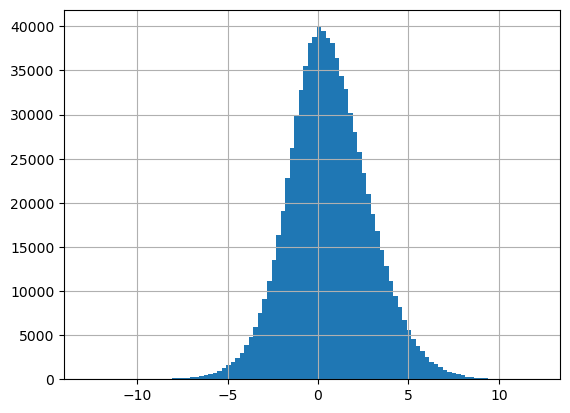

In [53]:
to_study = data.loc[(data.leverage != 0) & (data.leverage != 1)]
np.log(to_study.leverage / (1 - to_study.leverage)).hist(bins=100)

In [55]:
to_study = data.loc[(data.leverage != 0) & (data.leverage != 1)]
to_study = to_study.assign(logit_leverage=lambda x: np.log(x.leverage / (1 - x.leverage)))

to_study.to_csv(os.path.join(data_dir, "testing/cur_spark_ruslana_logit.csv"))